# Предобработка больших данных

*В это модуле мы займемся предобработкой данных.Эо считается самой важной частью в машинном обучении , так как от него зависит результат обучения модели.Что бы  обработать наши данные нам потребуется выпонить следующие пункты:*

* *Загрузка данных(и их изучение)*
* *Обработка пропущенных значений* 
* *Удаление неиформативных признаков*
* *Feature Engineering*

*Выполнения этих пунктов должно хватить для предобработки нашей выборки, и после этого модуля можно будет приступить к обучению.*

*Приступим к загрузки данных и библиотек:*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize']=(6,4)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import os
from fancyimpute import KNN
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,max_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_gamma_deviance

In [2]:
data=pd.read_csv('housing.csv')

In [3]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


*Теперь необходимо обработать пропущенные значения в данных.Существует три метода:*
* *Удаление призаков или значений(применять лучше если пропущенных значений отсутствует мало ,а выборка имеет большой размер)*
* *Замена пропщенных значений на моду числа или среднее или мелианное значение(считается самым стандартным способом)*
* *Предсказание пропщенных значений(здесь важно, что бы призанки имели зависимость от признаков с пропущенными значениями)*

*Что бы определить каким способом мы будем обрабатывать пропущенные значения, посмотрим на их колличество:*

In [4]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

*Так как пропущенных значений мало, и большиноство из них не случайно отсутствуют мы воспользуемся методом-заменой заменой пропущенных значений.Все категориальные признаки я заменю модой числа, а количественные-мелианным значением:*

In [5]:
data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace=True)

*Теперь проверим получилось ли у нас заменить пропущенные значения:*

In [6]:
data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
lbl=LabelEncoder()
df_nomic=data.select_dtypes(exclude=[np.number])
cols_nomic=df_nomic.columns.values
for col in cols_nomic:
    data[col]=lbl.fit_transform(data[col])

*Так же следует избавиться от слишком большого числа повторений , но это нужно делать только в количественных признаках,  признаку 'ocean_proximity' свойственно большое количество повторений, именно поэтому мы не будем его учитывать:*

In [8]:
row=len(data.index)
infor=[]
for col in data[['longitude','latitude','housing_median_age','total_rooms','population','households','median_income','median_house_value']]:
    counts=data[col].value_counts()
    soft=(counts/row).iloc[0]
    if soft>0.80:
        del data[col]
        print('{}-deleted'.format(col))

*Как видно, в данных не оказалось повторений, значит мы не будем нечего удалять.*

*Так же очень важно при предобработки в машинном обучении применить конструирование признаков.Конструирование-это процесс создания новых или преобразования старых признаков.Мы сделаем преобразование логарифмическое над целевыми признаками, так как оно считается наиболее подходящим в данных где преобладают числовые признаки:*

In [9]:
features = data.copy()
numeric_subset = data.select_dtypes('number')
for col in numeric_subset.columns:
    if col == 'longitude':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
categorical_subset = data

In [10]:
features = data.copy()
numeric_subset = data.select_dtypes('number')
for col in numeric_subset.columns:
    if col == 'latitude':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
categorical_subset = data

In [11]:
data = data.astype('int64')

*В конце предобработки я нормализую нашу выборку, что-бы все признаки кроме целевых стояли в дсапозоне от 1 до 0:*

In [12]:
scaler=MinMaxScaler()

In [13]:
scalers=scaler.fit_transform(data.drop('median_house_value', axis=1))
pd_scalers=pd.DataFrame(scalers, columns=data.drop('median_house_value', axis=1).columns)

In [14]:
df_scaler=scaler.fit_transform(data.drop('longitude', axis=1))
pd_df_scaler=pd.DataFrame(df_scaler, columns=data.drop('longitude', axis=1).columns)

In [15]:
df_scaler_lati=scaler.fit_transform(data.drop('latitude', axis=1))
pd_df_scaler_lati=pd.DataFrame(df_scaler, columns=data.drop('latitude', axis=1).columns)

# Классификация

*В этом модуле необходимо будет обучить признаки на выбранном классификаторе, для этого нужно будет выполнить следующие пункты :*

* *Отбор признаков*
* *Разбиение данных*
* *Обучение модели на классификаторе*
* *Feature Engineering*

*При выполнении этих пунктов, у нас будет обученные признаки на классификаторе.*

*Для начало нужно отобрать только хорошо зависимые от целевых переменных признаки, и с хорошим распределением, для этого нужно построить гистограмму распределения и диаграмму попарной зависимости:*  

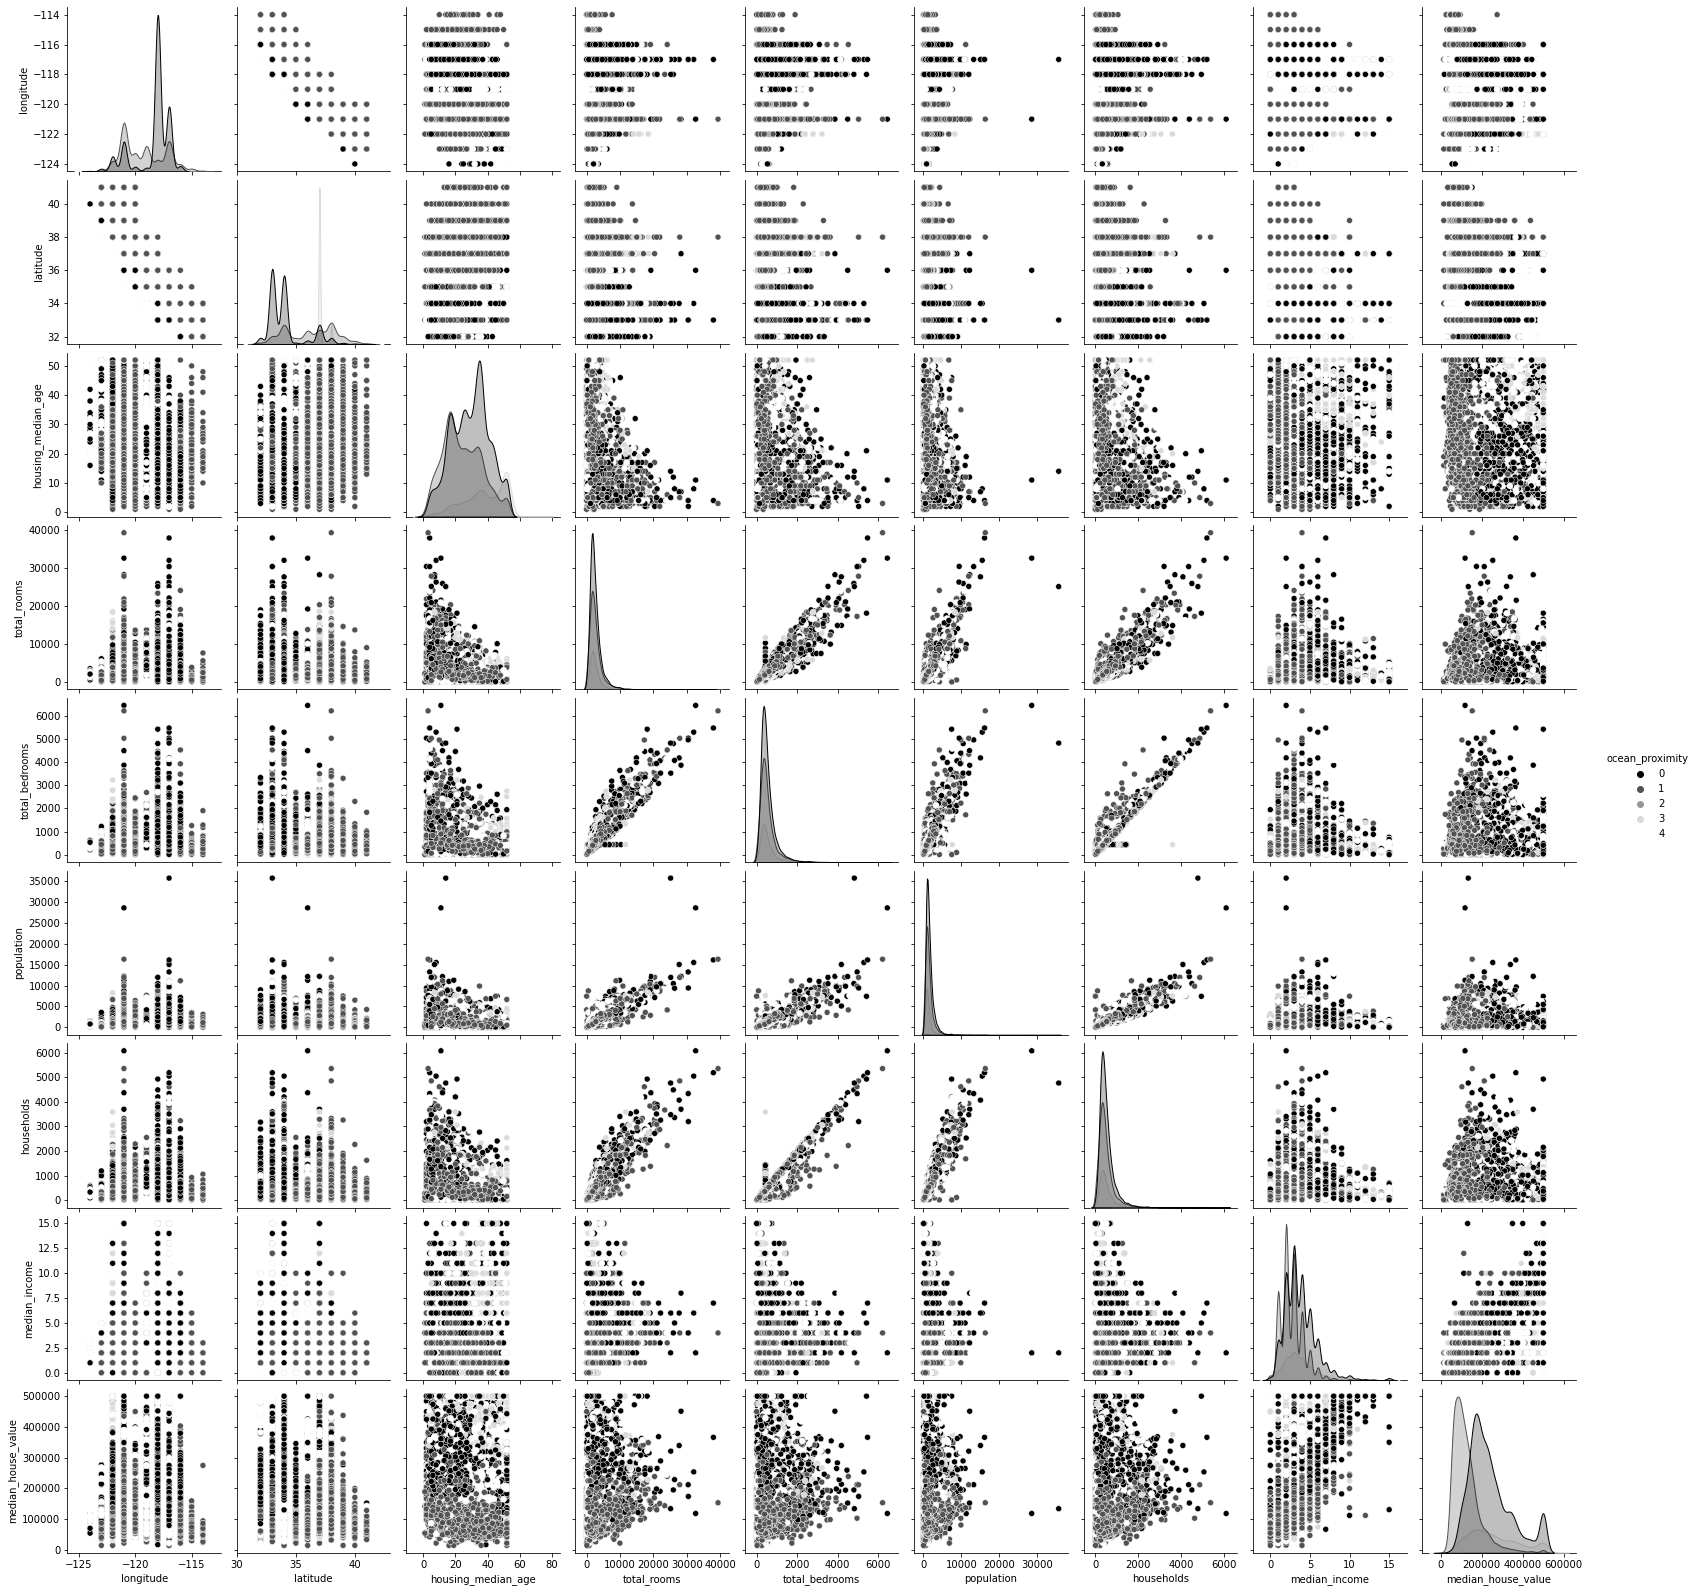

In [16]:
sns.pairplot(data, hue='ocean_proximity', palette='Greys_r');

*На диограмме распределения видно, что признаки предикторы хорошо зависят от целевых атрибутов, так как не имеют схожести с ними, а также все значения признаков расположены по всей плоскости, что тже свидетельствует о нормальной зависимости.*

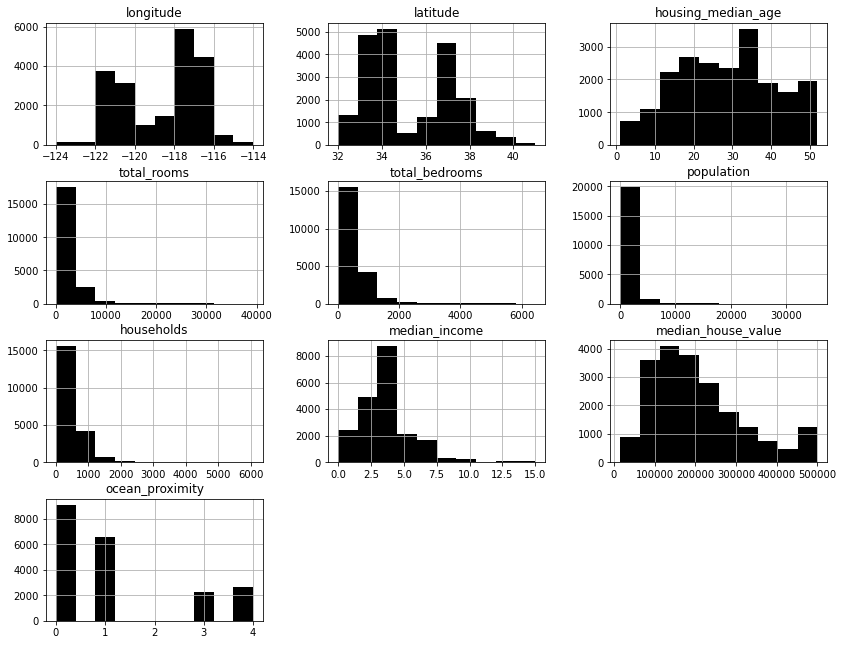

In [17]:
data.hist(color='k', figsize=(14,11));

*Из гистограммы распределеня можно сделать вывод, что признаки расположены семетрично, это значит, что здесь нету признаков, которые нужно было бы удалить.*

*Теперь посмотрим на коэффициент кореляции между двумя целевыми и предикторными признаками:*

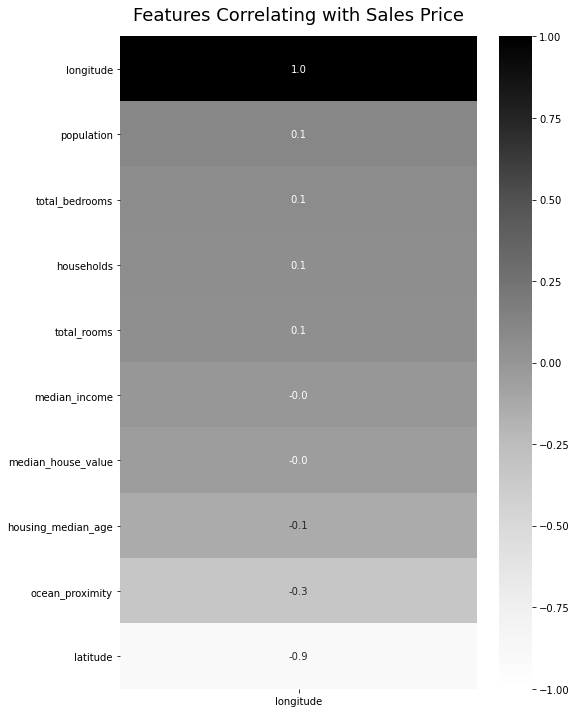

In [18]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['longitude']].sort_values(by='longitude', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Greys',fmt=".1f")
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

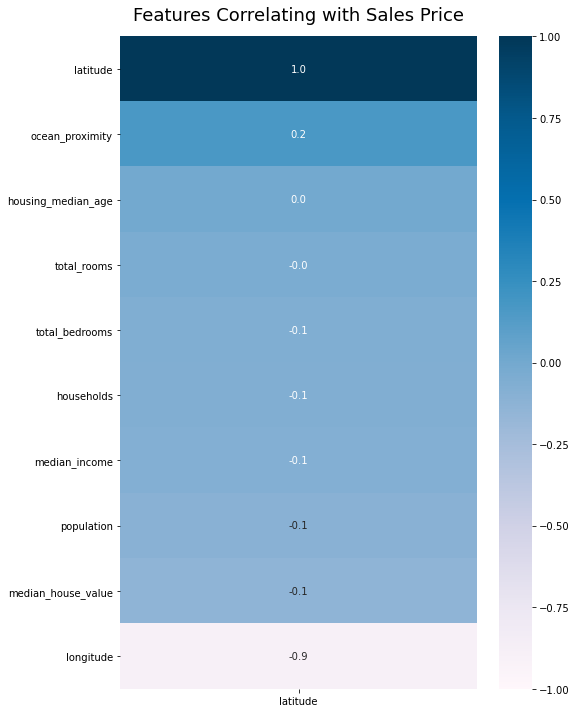

In [19]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['latitude']].sort_values(by='latitude', ascending=False), vmin=-1, vmax=1, annot=True, cmap='PuBu',fmt=".1f")
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

*Видно, что от целевой 'longitude', все признаки зависят хорошо, так как имеют корреляцию меньше 0.4, а вот от целевой переменной latitude, не все признаки хорошо зависят, поэтому удалим признак который имеет коэффициент корреляции больше 0.4:*

In [20]:
del pd_df_scaler_lati['ocean_proximity']

*Теперь разделим наши данные на тестувую и тренировочную части, что бы при поступлении новых данных наша модель давала правельные результаты,разделять данные можно многими способами, но я воспользуюсь самым стандартным train_test_split, так как его легче и удобнее всего применять при классификации:*

In [21]:
x=df_scaler.copy()
y=data['longitude']

In [22]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.33, random_state=10)

*Теперь разделим второй целевой признак:*

In [23]:
X=df_scaler_lati.copy()
Y=data['latitude']

In [24]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.3, random_state=20)

*После того, как мы разделили наши данные, можно приступить к выбору классификатора.Здесь мне кажется больше всего подойдет классификатор:k-ближайших соседей(он очень прост в реализации, и основан на вычислении ближайших точек), Дерево решений(также считается одним из простых алгоритмов), и возьмем  ансамблевый алгоритмы XGBoost*

*Обучение с помощью Дерева решений longitude:*

In [25]:
tree=DecisionTreeClassifier(random_state=20)

In [26]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=20)

In [27]:
y_pred=tree.predict(x_test)

In [28]:
tree.score(x_test, y_test)

0.7790663534938345

*Обучение с помощью Дерева решений latitude:*

In [29]:
tree=DecisionTreeClassifier(random_state=20)

In [30]:
tree.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=20)

In [31]:
Y_pred=tree.predict(X_test)

In [32]:
tree.score(X_test, Y_test)

0.6963824289405685

*Обучение с помощью k-ближайших соседей longitude:*

In [33]:
np.random.seed(9)
knn_clf=KNeighborsClassifier(n_neighbors=1)

In [34]:
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [35]:
y_pred = knn_clf.predict(x_test)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -124       0.97      0.86      0.91        37
        -123       0.69      0.57      0.62        44
        -122       0.90      0.91      0.90      1245
        -121       0.78      0.77      0.77      1043
        -120       0.40      0.43      0.42       338
        -119       0.71      0.73      0.72       470
        -118       0.83      0.81      0.82      1995
        -117       0.75      0.78      0.77      1420
        -116       0.66      0.48      0.56       174
        -115       0.75      0.79      0.77        34
        -114       0.23      0.25      0.24        12

    accuracy                           0.78      6812
   macro avg       0.70      0.67      0.68      6812
weighted avg       0.78      0.78      0.78      6812



In [37]:
knn_clf.score(x_test, y_test)

0.7805343511450382

*Обучение с помощью k-ближайших соседей latitude:*

In [38]:
np.random.seed(9)
knn_clf=KNeighborsClassifier(n_neighbors=1)

In [39]:
knn_clf.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=1)

In [40]:
Y_pred = knn_clf.predict(X_test)

In [41]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          32       0.79      0.81      0.80       390
          33       0.67      0.68      0.67      1471
          34       0.71      0.70      0.70      1506
          35       0.57      0.53      0.55       154
          36       0.69      0.70      0.69       379
          37       0.82      0.79      0.80      1362
          38       0.59      0.62      0.60       633
          39       0.34      0.38      0.36       168
          40       0.61      0.60      0.60       105
          41       0.17      0.17      0.17        24

    accuracy                           0.69      6192
   macro avg       0.60      0.60      0.60      6192
weighted avg       0.70      0.69      0.70      6192



In [42]:
knn_clf.score(X_test, Y_test)

0.6946059431524548

*Обучение с помощью XGBoost longitude:*

In [43]:
xgb=XGBClassifier(random_state=110,n_estmats=22, learning_rate=0.19,min_child_weight=1,gamma=0,subsample=0.9,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,seed=27)

In [44]:
xgb.fit(x_train, y_train)

[15:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estmats, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.19, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_estmats=22, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=110,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [45]:
y_pred=xgb.predict(x_test)

In [46]:
xgb.score(x_test, y_test)

0.8370522607163828

*Обучение с помощью XGBoost latitude:*

In [47]:
xgb=XGBClassifier(random_state=110,n_estmats=22, learning_rate=0.19,min_child_weight=1,gamma=0,subsample=0.9,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,seed=27)

In [48]:
xgb.fit(X_train, Y_train)

[15:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estmats, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.19, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_estmats=22, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=110,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [49]:
y_pred=xgb.predict(X_test)

In [50]:
xgb.score(X_test, Y_test)

0.7672803617571059

*Здесь можно сделать вывод, что лучшим классификатором и одного и другого признака является xgboost.*

*Feature Engineering*

*Что-бы точность модели была ещё лучше, воспользуемся настройкой параметров между признаками:*

In [66]:
tree=DecisionTreeClassifier(random_state=1)

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
params={"max_depth":np.arange(1,7,1),"min_samples_leaf":range(1,6,1)}

In [71]:
grid=GridSearchCV(tree, params, cv=5, n_jobs= -1)

In [72]:
%%timeit
grid.fit(x_train, y_train)

10.1 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 5}

In [74]:
best_tree = grid.best_estimator_

In [75]:
y_pred = best_tree.predict(x_test)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       26900       0.00      0.00      0.00         1
       27500       0.00      0.00      0.00         1
       30000       0.00      0.00      0.00         1
       32500       0.00      0.00      0.00         1
       32900       0.00      0.00      0.00         1
       34600       0.00      0.00      0.00         1
       36700       0.00      0.00      0.00         1
       37500       0.00      0.00      0.00         1
       38800       0.00      0.00      0.00         1
       40000       0.00      0.00      0.00         1
       40900       0.00      0.00      0.00         1
       41500       0.00      0.00      0.00         1
       42100       0.00      0.00      0.00         1
       42500       0.00      0.00      0.00         5
       42600       0.00      0.00      0.00         1
       42700       0.00      0.00      0.00         1
       43000       0.00      0.00      0.00         2
       43100       0.00    

In [77]:
grid.best_score_

0.04809104091401793

# Восстановление регрессии

*В этом модуле мы будем прогнозировать переменную median_house_value на алгоритмов регрессии.Для того, что-бы это успешно сделать, необходимо выполнить следующие пункты:*
* *Отбор признаков*
* *Разделение данных*
* *Прогнозирование*

*Для начало, можно посмотреть тепловой график, по которому определиться зависимость:*

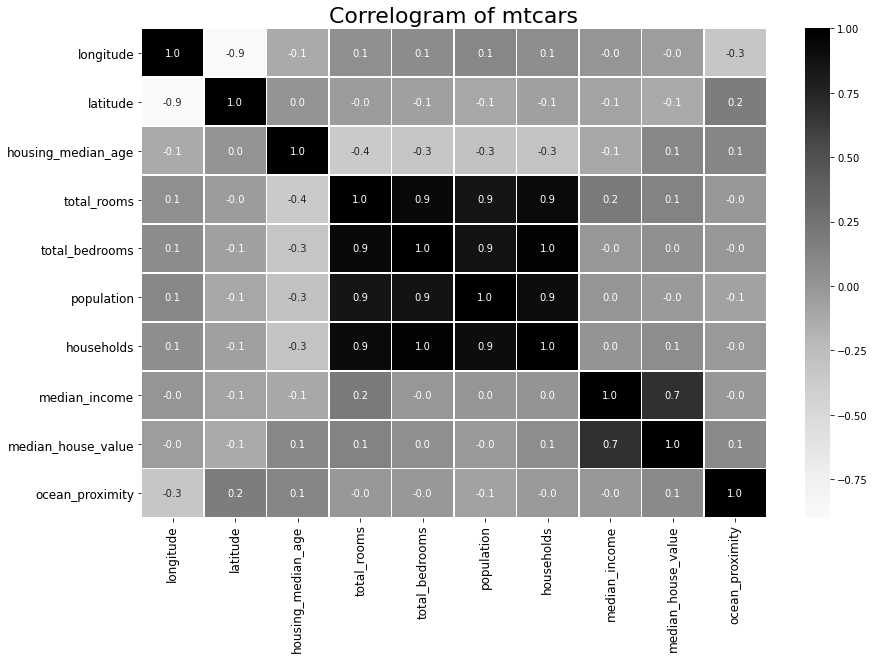

In [51]:
plt.figure(figsize=(14,9))
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr()
.columns, cmap='Greys', center=0, annot=True,fmt=".1f",linewidths=.7,)
plt.show()

*На диаграмме видно, что некоторые признаки имеют в зависимости с median_house_value плохую зависимость, и они нам будут мешать получить хорошие результаты в обчении, поэтому их необходимо удалить:*

In [52]:
del data['total_rooms']
del data['median_income']

*В регрессии мы воспользуемся тем же методом разделения данных , что и рпи классификации, так как он наиболее удобный и простой в реализации:*

In [53]:
x=scalers.copy()
y=data['median_house_value']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.33, random_state=10)

*Теперь необходимо выбрать модели регрессии.Я буду использовать для прогноза алгоритм Дерево Решений Регрессия( он отслеживает особенности объекта), Регрессия Лассо( это аналог линейной регрессии, но более простой в реализации), Pегрессия ElasticNet(этот алгоритм пытается обеденить в себе лучшее из гребневой регрессии и рагресии лассо).*

*Регрессия Дерево решений*

In [54]:
model = DecisionTreeRegressor()

In [55]:
model.fit(X_train, Y_train)

DecisionTreeRegressor()

In [56]:
y_pred=model.predict(X_test)

In [57]:
print("Максимальная остаточная ошибка: {}".format(max_error(Y_test,y_pred)))

Максимальная остаточная ошибка: 5.0


*Pегрессия LASSO*

In [58]:
lass=Lasso()

In [59]:
lass.fit(X_train, Y_train)

Lasso()

In [60]:
y_pred=lass.predict(X_test)

In [61]:
print("Максимальная остаточная ошибка: {}".format(max_error(Y_test,y_pred)))

Максимальная остаточная ошибка: 5.896456256921375


*Pегрессия ElasticNet*

In [62]:
elact=ElasticNetCV()

In [63]:
elact.fit(X_train, Y_train)

ElasticNetCV()

In [64]:
y_pred=elact.predict(X_test)

In [65]:
print("Максимальная остаточная ошибка: {}".format(max_error(Y_test,y_pred)))

Максимальная остаточная ошибка: 4.501635638574761
